In [15]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA, SparsePCA, KernelPCA, NMF
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf

In [16]:
# Takes 6 minutes to load the data if this is your first time
lfw_people = fetch_lfw_people(min_faces_per_person=100)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
k=4

In [35]:
def spca_exp(X_scaled,k):
    alpha_vals=[0.005]
    ridge_alpha=0.0

    best_spca_alpha=0.0
    best_spca_alpha_err=math.inf
    for idx in range(len(alpha_vals)):
        alpha=alpha_vals[idx]
        spca = SparsePCA(n_components=k, ridge_alpha=ridge_alpha, alpha=alpha).fit(X_scaled)
        X_reduced = spca.transform(X_scaled)
        X_recon = spca.inverse_transform(X_reduced)
        spca_err=mean_squared_error(X_scaled, X_recon)
        print("alpha=",alpha,"err=",spca_err)
        if spca_err < best_spca_alpha_err:
            best_spca_alpha_err=spca_err
            best_spca_alpha=alpha
            best_eigenfaces_spca = spca.components_.reshape((k,h,w))
    
    print("\n\nBest SPCA:")
    print("- alpha:",best_spca_alpha)
    print("- err:",best_spca_alpha_err)
    
    return best_spca_alpha, best_spca_alpha_err, best_eigenfaces_spca

In [36]:
best_spca_alpha, best_spca_alpha_err, best_eigenfaces_spca = spca_exp(X_scaled,k)

alpha= 0.005 err= 0.014996763


Best SPCA:
- alpha: 0.005
- err: 0.014996763


In [19]:
def kernel_exp(X_scaled,k):

    lin_pca = KernelPCA(n_components = k, kernel="linear", fit_inverse_transform=True)
    rbf_pca = KernelPCA(n_components = k, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
    sig_pca = KernelPCA(n_components = k, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

    kernel_options=((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$"))

    best_kernel=""
    best_kernel_err=math.inf
    for subplot, pca, title in kernel_options:
        X_reduced = pca.fit_transform(X_scaled)
        X_recon = pca.inverse_transform(X_reduced)
        err=mean_squared_error(X_scaled, X_recon)
        print("Kernel PCA (",title,") MSE reconstruction loss:",err)
        if err < best_kernel_err:
            best_kernel=title
            best_kernel_err=err
            print("- New best kernel")

    print("\n\nBest MSE reconstruction error:",best_kernel_err)
    print("- Kernel:",best_kernel)
    
    return best_kernel, best_kernel_err

In [20]:
best_kernel, best_kernel_err = kernel_exp(X_scaled,k)

Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.286655
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.025536971
- New best kernel
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 0.028402172


Best MSE reconstruction error: 0.025536971
- Kernel: RBF kernel, $\gamma=0.04$


In [21]:
def autoencoder_exp(X_scaled, k):
    input_dim = X_scaled.shape[1] #input shape
    output_dim = X_scaled.shape[1]
    encoding_dim = k # encoding dimension - #neurons for the dense layers
    optimizer = 'adam'
    loss = 'mse'

    input_layer = tf.keras.Input(shape=(input_dim,), name='input') # input layer
    encoding_layer = tf.keras.layers.Dense(encoding_dim, name='encoding')(input_layer) # encoding layer
    decoding_layer = tf.keras.layers.Dense(output_dim, name='decoding')(encoding_layer) # decoding layer

    autoencoder = tf.keras.Model(input_layer, decoding_layer)
    autoencoder.compile(optimizer=optimizer, loss=loss)
    autoencoder.summary()
    
    # Set other parameters
    epochs=50
    batch_size=16
    shuffle=True
    validation_split=0.1
    verbose=0

    # early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)

    history = autoencoder.fit(X_scaled, X_scaled,
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=shuffle,
                              validation_split=validation_split,
                              verbose=verbose)
    #                           callbacks=[early_stop])

    # Plot the loss 
    plt.plot(history.history['loss'], color='#FF7E79',linewidth=3, alpha=0.5)
    plt.plot(history.history['val_loss'], color='#007D66', linewidth=3, alpha=0.4)
    plt.title('Model train vs Validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.grid(True)
    plt.show()    
    
    print("Training loss:", history.history['loss'][-1])
    print("Validation loss:", history.history['val_loss'][-1])    
    
        
    autoencoder_err=mean_squared_error(X_scaled, autoencoder(X_scaled))
    print("MSE=",autoencoder_err)
    
    return None, autoencoder_err

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2914)]            0         
                                                                 
 encoding (Dense)            (None, 4)                 11660     
                                                                 
 decoding (Dense)            (None, 2914)              14570     
                                                                 
Total params: 26,230
Trainable params: 26,230
Non-trainable params: 0
_________________________________________________________________


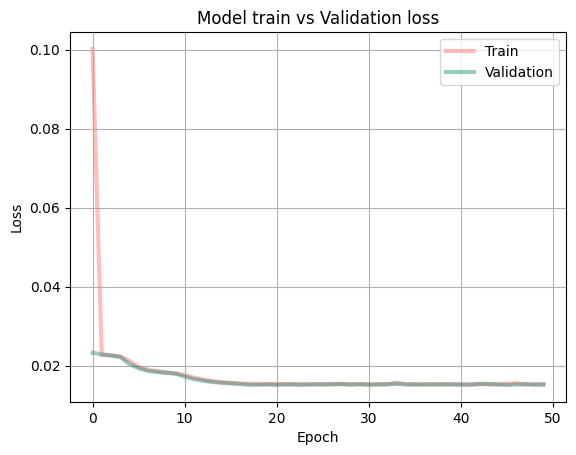

Training loss: 0.015252313576638699
Validation loss: 0.015240504406392574
MSE= 0.015233325


In [22]:
_,best_autoencoder_err = autoencoder_exp(X_scaled, k)

In [27]:
def nmf_exp(X_scaled, k):
    nmf = NMF(n_components=k, init='random', max_iter=10000, random_state=109).fit(X_scaled)
    X_reduced = nmf.transform(X_scaled)
    X_recon = nmf.inverse_transform(X_reduced)
    nmf_err=mean_squared_error(X_scaled, X_recon)
    eigenfaces_nmf = nmf.components_.reshape((k,h,w))
    print("NMF MSE reconstruction loss:", nmf_err)
        
    return nmf_err, eigenfaces_nmf

In [28]:
nmf_err, eigenfaces_nmf = nmf_exp(X_scaled, k)

NMF MSE reconstruction loss: 0.015102579


In [29]:
def plot_gallery(images, titles, h, w, n_row=1, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(4):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

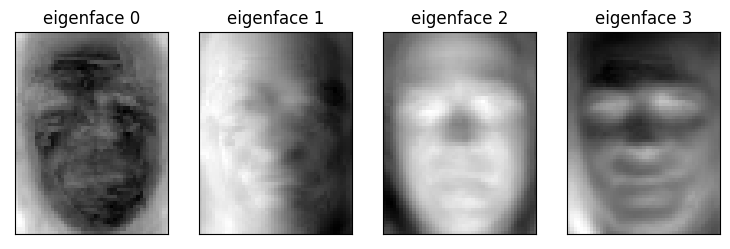

In [37]:
eigenface_titles_spca = [f"eigenface {i}" for i in range(best_eigenfaces_spca.shape[0])]
plot_gallery(best_eigenfaces_spca, eigenface_titles_spca, h, w)

plt.show()

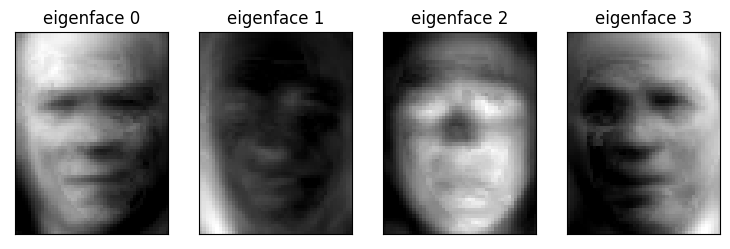

In [32]:
eigenface_titles_nmf = [f"eigenface {i}" for i in range(eigenfaces_nmf.shape[0])]
plot_gallery(eigenfaces_nmf, eigenface_titles_nmf, h, w)

plt.show()
